In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]
X_train_aug = aug_train_processed[features]
y_train_aug = aug_train_processed[target]

y_test  =org_test_processed[target]
X_test  =org_test_processed[features]

In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt

In [10]:
# ------------------ TSMixer Model ------------------
class TSMixerBlock(nn.Module):
    def __init__(self, seq_len, hidden_dim, dropout=0.0):
        super().__init__()

        # Token mixing
        self.token_norm = nn.LayerNorm(hidden_dim)
        self.token_mlp = nn.Sequential(
            nn.Linear(seq_len, seq_len * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(seq_len * 2, seq_len),
            nn.Dropout(dropout)
        )

        # Channel mixing
        self.channel_norm = nn.LayerNorm(hidden_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Token mixing
        y = self.token_norm(x)
        y = y.transpose(1, 2)  # [batch, hidden_dim, seq_len]
        y = self.token_mlp(y)
        y = y.transpose(1, 2)
        x = x + y

        # Channel mixing
        y = self.channel_norm(x)
        y = self.channel_mlp(y)
        x = x + y

        return x


class TSMixer(nn.Module):
    def __init__(self, seq_len, n_features, forecast_horizon, num_blocks=4, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.input_layer = nn.Linear(n_features, hidden_dim)
        self.mixer_blocks = nn.ModuleList([
            TSMixerBlock(seq_len, hidden_dim, dropout)
            for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, forecast_horizon)

    def forward(self, x):
        # x shape: [batch, seq_len, n_features]
        x = self.input_layer(x)
        for block in self.mixer_blocks:
            x = block(x)
        x = x.mean(dim=1)  # Global average pooling over seq_len
        out = self.output_layer(x)
        return out


In [11]:
# ------------------ Dataset Preparation ------------------
def create_sequences(X_data, y_data, seq_len, forecast_horizon):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len - forecast_horizon):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len:i+seq_len+forecast_horizon].values)
    return np.array(X_seq), np.array(y_seq)

In [12]:
import numpy as np

def desequence(predictions, seq_len, forecast_horizon):
    """
    Reconstruct continuous forecast from overlapping forecasted sequences.
    
    Arguments:
        predictions: numpy array of shape (num_sequences, forecast_horizon)
        seq_len: input sequence length used during training
        forecast_horizon: forecast horizon length
        
    Returns:
        merged_forecast: reconstructed continuous forecast (1D array)
    """
    total_length = len(predictions) + seq_len + forecast_horizon - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start_idx = i + seq_len
        end_idx = start_idx + forecast_horizon
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1

    # Average overlapping forecasts
    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]

    return merged_forecast


In [13]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_org), columns=features)
X_seq, y_seq = create_sequences(X_train_scaled, y_train_org, 24, 12)


In [14]:
X_train_org.shape

(140068, 54)

In [15]:


# Also reconstruct actual values:
merged_true = desequence(y_seq, 24, 12)


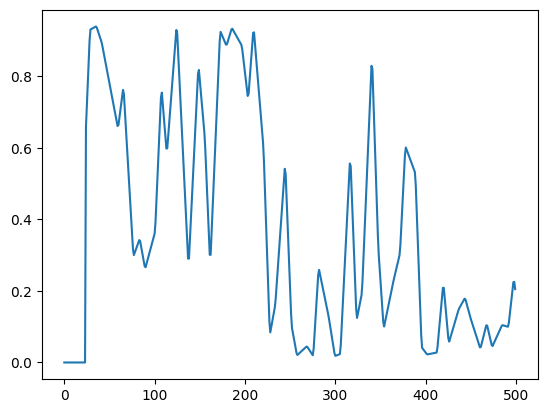

In [16]:
plt.plot(merged_true[:500])

In [17]:
import os
import torch
from tqdm import tqdm

# ------------------ Training Function with Checkpointing ------------------
def train_model(X_train, y_train, features, seq_len, forecast_horizon, epochs=10, batch_size=32, checkpoint_path="tsmixer_checkpoint.pth"):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
    
    X_seq, y_seq = create_sequences(X_train_scaled, y_train, seq_len, forecast_horizon)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32)

    train_dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    model = TSMixer(seq_len, len(features), forecast_horizon)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    start_epoch = 0
    # ------------------ Load Checkpoint if Exists ------------------
    if os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        start_epoch = checkpoint['epoch'] + 1

    # ------------------ Training Loop ------------------
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for xb, yb in loop:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Save checkpoint at the end of each epoch
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }, checkpoint_path)

    return model, scaler


In [18]:
# ------------------ Full Evaluation & Plotting Function ------------------
def evaluate_model_full_plot(model, scaler, X_test, y_test, features, seq_len, forecast_horizon,
                              time_index=None, plot_start=0, plot_end=None):
    # Scale and prepare test sequences
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    X_seq, y_seq = create_sequences(X_test_scaled, y_test, seq_len, forecast_horizon)

    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor).numpy()

    # Desequence both predictions and true values
    merged_pred = desequence(preds, seq_len, forecast_horizon)
    merged_true = desequence(y_seq, seq_len, forecast_horizon)

    # Compute metrics
    mse = mean_squared_error(merged_true, merged_pred)
    mae = mean_absolute_error(merged_true, merged_pred)
    rmse = math.sqrt(mse)
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Apply slicing range
    if plot_end is None:
        plot_end = len(merged_true)

    # Prepare x-axis
    if time_index is not None:
        time_index = time_index[-len(merged_true):]
        plot_range = time_index[plot_start:plot_end]
    else:
        plot_range = range(plot_start, plot_end)

    # Plotting
    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true[plot_start:plot_end], label='Actual', color='black')
    plt.plot(plot_range, merged_pred[plot_start:plot_end], label='Forecast', color='red', linestyle='--')
    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title(f"TSMixer Forecast vs Actual [{plot_start}:{plot_end}]")

    plt.legend(loc='upper right')
    plt.grid(True)

    # Add MAE and RMSE on the plot
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.02, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.show()


In [19]:
print("Training on original data...")
model_org, scaler_org = train_model(X_train_org, y_train_org, features, seq_len=24, forecast_horizon=12, epochs=100)


Training on original data...


Epoch 1, Loss: 0.0274


Epoch 2, Loss: 0.0205


Epoch 3, Loss: 0.0190


Epoch 4, Loss: 0.0182


Epoch 5, Loss: 0.0176


Epoch 6, Loss: 0.0171


Epoch 7, Loss: 0.0167


Epoch 8, Loss: 0.0163


Epoch 9, Loss: 0.0160


Epoch 10, Loss: 0.0158


Epoch 11, Loss: 0.0155


Epoch 12, Loss: 0.0152


Epoch 13, Loss: 0.0149


Epoch 14, Loss: 0.0147


Epoch 15, Loss: 0.0144


Epoch 16, Loss: 0.0141


Epoch 17, Loss: 0.0139


Epoch 18, Loss: 0.0136


Epoch 19, Loss: 0.0133


Epoch 20, Loss: 0.0130


Epoch 21, Loss: 0.0127


Epoch 22, Loss: 0.0124


Epoch 23, Loss: 0.0122


Epoch 24, Loss: 0.0119


Epoch 25, Loss: 0.0115


Epoch 26, Loss: 0.0112


Epoch 27, Loss: 0.0109


Epoch 28, Loss: 0.0105


Epoch 29, Loss: 0.0103


Epoch 30, Loss: 0.0101


Epoch 31, Loss: 0.0099


Epoch 32, Loss: 0.0095


Epoch 33, Loss: 0.0093


Epoch 34, Loss: 0.0092


Epoch 35, Loss: 0.0090


Epoch 36, Loss: 0.0087


Epoch 37, Loss: 0.0087


Epoch 38, Loss: 0.0084


Epoch 39, Loss: 0.0084


Epoch 40, Loss: 0.0084


Epoch 41, Loss: 0.0082


Epoch 42, Loss: 0.0082


Epoch 43, Loss: 0.0081


Epoch 44, Loss: 0.0077


Epoch 45, Loss: 0.0078


Epoch 46, Loss: 0.0078


Epoch 47, Loss: 0.0075


Epoch 48, Loss: 0.0075


Epoch 49, Loss: 0.0074


Epoch 50, Loss: 0.0071


Epoch 51, Loss: 0.0072


Epoch 52, Loss: 0.0072


Epoch 53, Loss: 0.0072


Epoch 54, Loss: 0.0071


Epoch 55, Loss: 0.0068


Epoch 56, Loss: 0.0070


Epoch 57, Loss: 0.0066


Epoch 58, Loss: 0.0066


Epoch 59, Loss: 0.0065


Epoch 60, Loss: 0.0065


Epoch 61, Loss: 0.0065


Epoch 62, Loss: 0.0063


Epoch 63, Loss: 0.0064


Epoch 64, Loss: 0.0063


Epoch 65, Loss: 0.0063


Epoch 66, Loss: 0.0062


Epoch 67, Loss: 0.0062


Epoch 68, Loss: 0.0061


Epoch 69, Loss: 0.0059


Epoch 70, Loss: 0.0059


Epoch 71, Loss: 0.0060


Epoch 72, Loss: 0.0060


Epoch 73, Loss: 0.0058


Epoch 74, Loss: 0.0059


Epoch 75, Loss: 0.0058


Epoch 76, Loss: 0.0057


Epoch 77, Loss: 0.0057


Epoch 78, Loss: 0.0058


Epoch 79, Loss: 0.0055


Epoch 80, Loss: 0.0057


Epoch 81, Loss: 0.0056


Epoch 82, Loss: 0.0058


Epoch 83, Loss: 0.0054


Epoch 84, Loss: 0.0056


Epoch 85, Loss: 0.0054


Epoch 86, Loss: 0.0054


Epoch 87, Loss: 0.0054


Epoch 88, Loss: 0.0054


Epoch 89, Loss: 0.0053


Epoch 90, Loss: 0.0053


Epoch 91, Loss: 0.0053


Epoch 92, Loss: 0.0052


Epoch 93, Loss: 0.0053


Epoch 94, Loss: 0.0051


Epoch 95, Loss: 0.0052


Epoch 96, Loss: 0.0051


Epoch 97, Loss: 0.0050


Epoch 98, Loss: 0.0049


Epoch 99, Loss: 0.0052


Epoch 100, Loss: 0.0052


In [24]:
# Save trained model weights
File_name = '../weights'
os.makedirs(File_name,exist_ok=True)
torch.save(model_org.state_dict(), f'{File_name}/tsmixer_org_no_shuffle.pth')
print("Model weights saved as 'tsmixer_org_no_shuffle.pth'")


Model weights saved as 'tsmixer_org_no_shuffle.pth'


In [69]:
print("Training on augmented data...")
model_aug, scaler_aug = train_model(X_train_aug, y_train_aug, features, seq_len=24, forecast_horizon=12,  epochs=2)

Training on augmented data...


In [ ]:
import joblib

In [ ]:
#  Save trained model weights
File_name = './weights'
os.makedirs(File_name,exist_ok=True)
torch.save(model_aug.state_dict(), f'{File_name}/tsmixer_aug.pth')
print("Model weights saved as 'tsmixer_aug.pth'")
# Save scaler using joblib (more robust for sklearn objects)
scaler_path = "scaler_tsmixer_aug.pkl"
joblib.dump(scaler_aug, f'{File_name}/{scaler_path}')

print("Model and scaler saved successfully.")


Evaluating model trained on original data:
Test MSE: 0.0163, MAE: 0.1001, RMSE: 0.1275


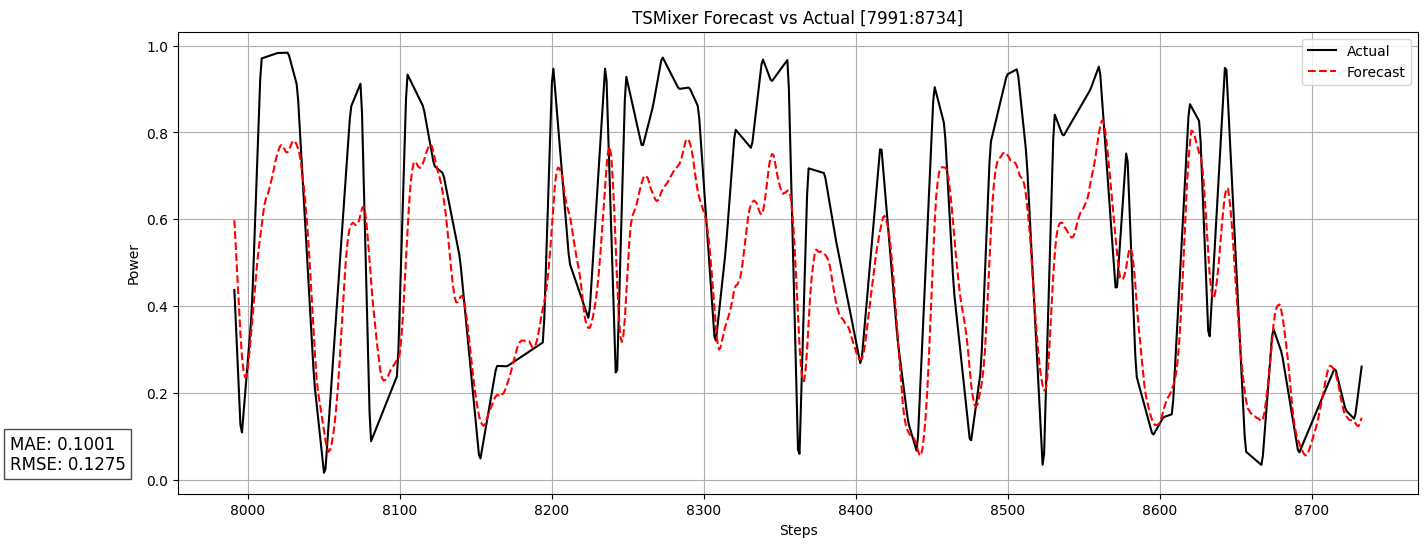

Test MSE: 0.0163, MAE: 0.1001, RMSE: 0.1275


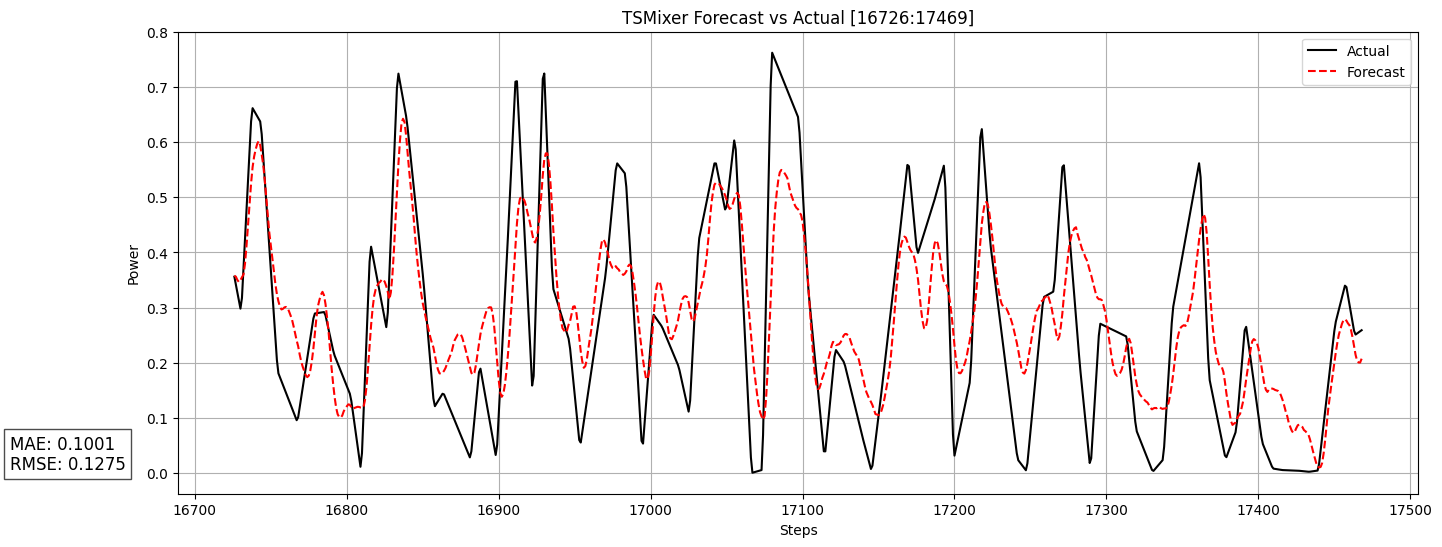

Test MSE: 0.0163, MAE: 0.1001, RMSE: 0.1275


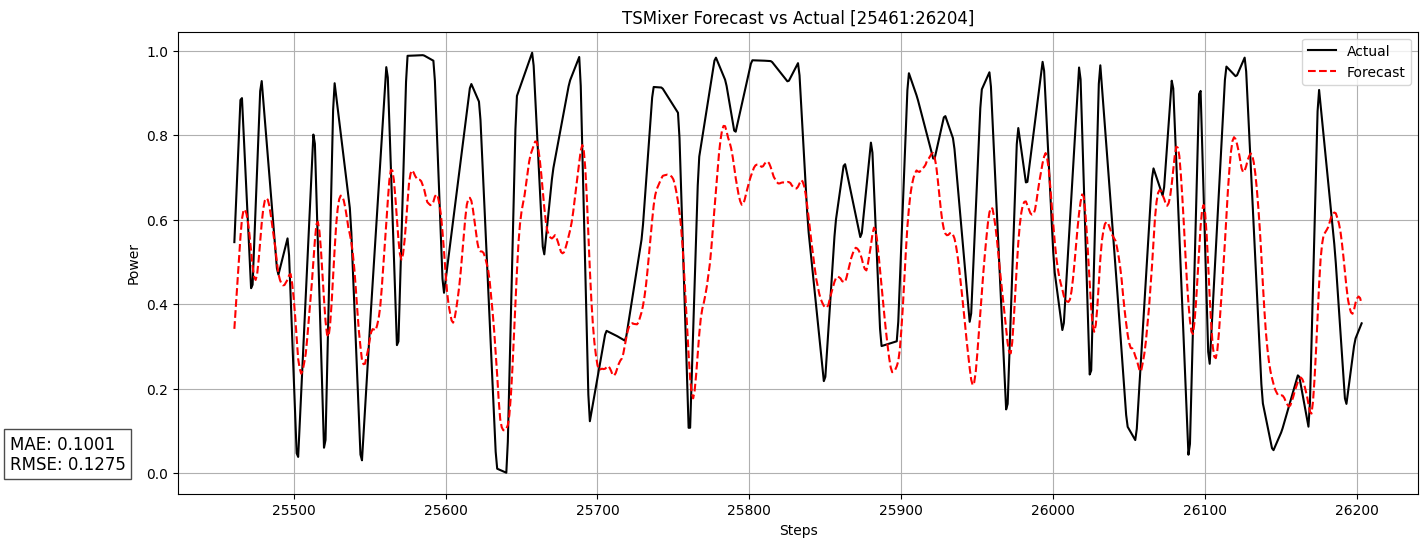

Test MSE: 0.0163, MAE: 0.1001, RMSE: 0.1275


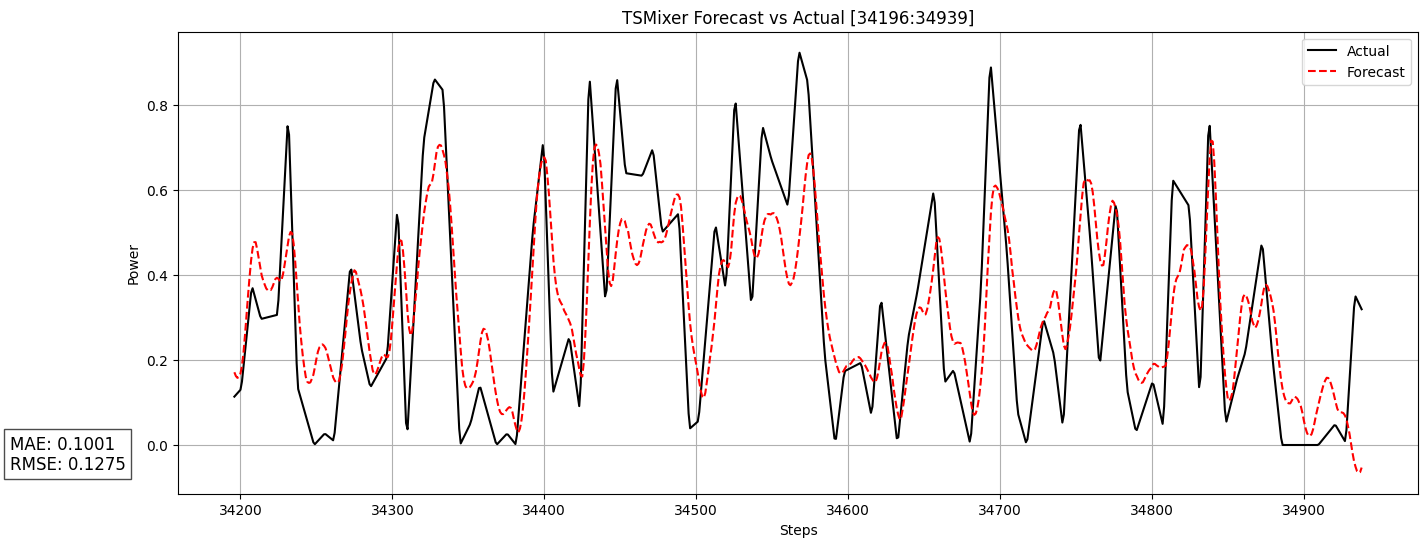

In [20]:
    # Testing

print("\nEvaluating model trained on original data:")
evaluate_model_full_plot(model_org, scaler, X_test, y_test, features, seq_len=24, forecast_horizon=12, plot_start=7991, plot_end=8734)
evaluate_model_full_plot(model_org, scaler, X_test, y_test, features, seq_len=24, forecast_horizon=12, plot_start=16726, plot_end=17469)
evaluate_model_full_plot(model_org, scaler, X_test, y_test, features, seq_len=24, forecast_horizon=12, plot_start=25461, plot_end=26204)
evaluate_model_full_plot(model_org, scaler, X_test, y_test, features, seq_len=24, forecast_horizon=12, plot_start=34196, plot_end=34939)

